In [1]:
# 시뮬레이션 라이브러리 불러오기
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
import sys

# 물질 설정 및 Refractive Index 설정
mp.verbosity(0)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1.0)

In [2]:
resolution = 10 

design_region_width = 4 
design_region_height = 2 
pml_size = 1.0 


Sx = 2 * pml_size + design_region_width 
Sy = 2 * pml_size + design_region_height + 5
cell_size = mp.Vector3(Sx, Sy)

In [3]:

wavelengths = np.array([1.5, 1.55, 1.6])

frequencies = 1/wavelengths
nf = len(frequencies) 

minimum_length = 0.09 
eta_i = 0.5  
eta_e = 0.55  
eta_d = 1 - eta_e  
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

pml_layers = [mp.PML(pml_size)]

fcen_0 = frequencies[0]
width = 0.1
fwidth_0 = width * fcen_0

fcen_1 = frequencies[1]
fwidth_1 = width * fcen_1

fcen_2 = frequencies[2]
fwidth_2 = width * fcen_2

In [4]:
source_center = [0, -(design_region_height / 2 + 1.5), 0] # Source 위치
source_size = mp.Vector3(Sx, 0, 0)
src_0 = mp.GaussianSource(frequency=fcen_0, fwidth=fwidth_0, is_integrated=True)
src_1 = mp.GaussianSource(frequency=fcen_1, fwidth=fwidth_1, is_integrated=True)
src_2 = mp.GaussianSource(frequency=fcen_2, fwidth=fwidth_2, is_integrated=True)
source = [mp.Source(src_0, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_1, component=mp.Ez, size=source_size, center=source_center),
          mp.Source(src_2, component=mp.Ez, size=source_size, center=source_center)]

In [5]:
# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_height)) + 1

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()

In [6]:

# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    )
]

In [7]:

# Meep simulation 세팅
sim = mp.Simulation(
    cell_size=cell_size, # cell_size = mp.Vector3(Sx, Sy)
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
)

In [8]:
monitor_position, monitor_size = mp.Vector3(0,design_region_height/2+1.5), mp.Vector3(0.01,0) 
FourierFields = mpa.FourierFields(
    sim,mp.Volume(center=monitor_position,size=monitor_size),
    mp.Ez,yee_grid=True)
ob_list = [FourierFields]

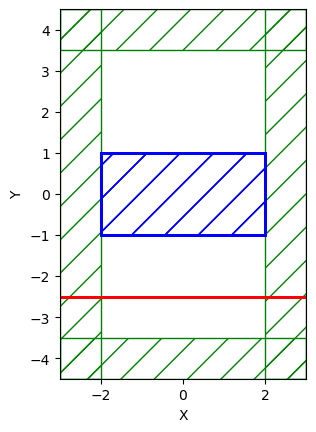

In [9]:
#def J(fields):
#    return npa.mean(npa.abs(fields[:,1]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

def J0(fields):
    return npa.mean(npa.abs(fields[0,1]) ** 2) 
def J1(fields):
    return npa.mean(npa.abs(fields[1,1]) ** 2)
def J2(fields):
    return npa.mean(npa.abs(fields[2,1]) ** 2)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J0,J1,J2],
    #objective_functions=J
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    maximum_run_time=2000,
)
opt.plot2D(True)

In [10]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient
    # f0, dJ_du = opt()
    
    # Adjoint gradient
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

# plot 기능
    # plt.figure()
    # ax = plt.gca()
    # opt.plot2D(
    #     False,
    #     ax=ax,
    #     plot_sources_flag=False,
    #     plot_monitors_flag=False,
    #     plot_boundaries_flag=False,
    # )
    # circ = Circle((2, 2), minimum_length / 2)
    # ax.add_patch(circ)
    # ax.axis("off")
    # plt.show()

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [11]:
algorithm = nlopt.LD_MMA # 어떤 알고리즘으로 최적화를 할 것인가?
# MMA : 점근선 이동

n = Nx * Ny  # number of parameters

# Initial guess - 초기 시작값 0.5
x = np.ones((n,)) * 0.5

# lower and upper bounds (상한 : 1, 하한 : 0)
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

# Optimization parameter
cur_beta = 4
beta_scale = 1.5 
num_betas = 9 
update_factor = 12  # number of iterations between beta updates
ftol = 1e-5 

# for iters in range(num_betas):
#     solver = nlopt.opt(algorithm, n)
#     solver.set_lower_bounds(lb) # lower bounds
#     solver.set_upper_bounds(ub) # upper bounds
#     solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
#     # solver.set_max_objective(lambda a, g: f1(a, g, cur_beta), lambda a, g: f2(a, g, cur_beta), lambda a, g: f3(a, g, cur_beta)) # Set the objective function to be maximized
#     solver.set_maxeval(update_factor) # Set the maximum number of function evaluations
#     solver.set_ftol_rel(ftol) # Set the relative tolerance for convergence
#     x[:] = solver.optimize(x)
#     cur_beta = cur_beta * beta_scale # Update the beta value for the next iteration

In [12]:
f0, dJ_du = opt([mapping(x, eta_i, cur_beta / beta_scale)], need_gradient=True)

Starting forward run...
Starting adjoint run...


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: divide by zero encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)
/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: invalid value encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


Calculating gradient...


In [13]:
print(f0)

[15.375195759303324, 19.41682615142288, 16.196529333791183]


In [13]:
print(dJ_du)

[[-1.74133918 -1.21935845  0.03455427]
 [-1.07444992  0.14403088 -0.13696121]
 [-0.72989663  0.54005436 -0.41047741]
 ...
 [-0.20855779 -0.70598122  0.24751129]
 [ 0.01376826 -0.33319574  0.29084999]
 [-0.24856526  0.87630852  0.08691025]]


In [14]:
dJ_du_0 = dJ_du[:,0]
dJ_du_1 = dJ_du[:,1]
dJ_du_2 = dJ_du[:,2]

dJ_du_3=dJ_du_0+dJ_du_1+dJ_du_2

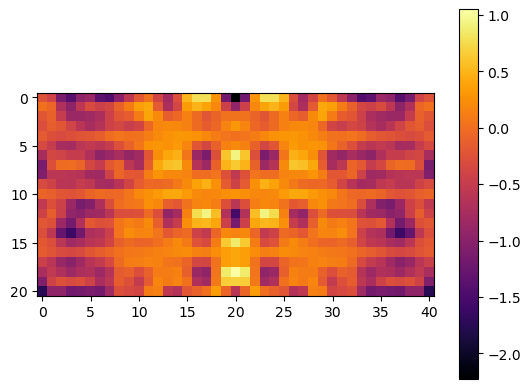

In [15]:
plt.figure()
plt.imshow(np.rot90(dJ_du_0.reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_0), vmax=np.max(dJ_du_0))
plt.colorbar()

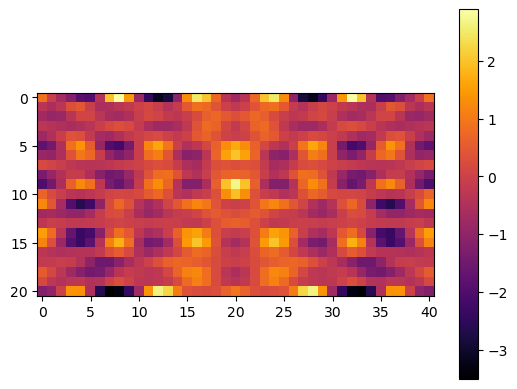

In [16]:
plt.figure()
plt.imshow(np.rot90(dJ_du_1.reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_1), vmax=np.max(dJ_du_1))
plt.colorbar()

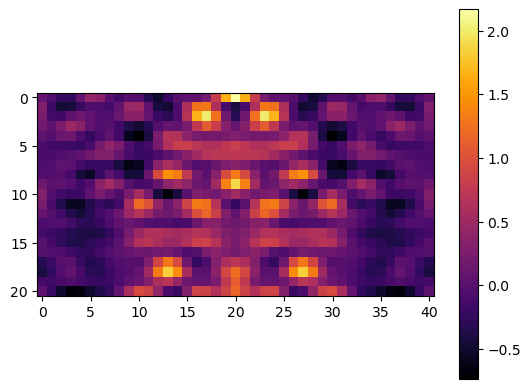

In [17]:
plt.figure()
plt.imshow(np.rot90(dJ_du_2.reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_2), vmax=np.max(dJ_du_2))
plt.colorbar()

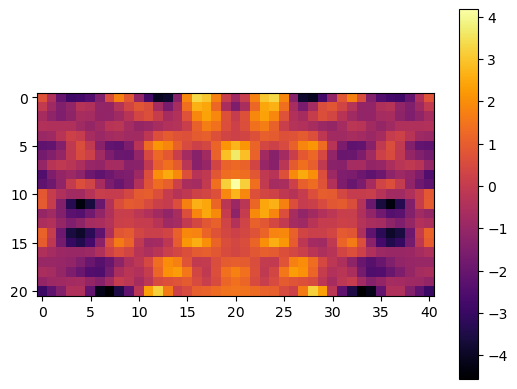

In [18]:
plt.figure()
plt.imshow(np.rot90(dJ_du_3.reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_3), vmax=np.max(dJ_du_3))
plt.colorbar()

In [19]:
db = 1e-3
choose = 861
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

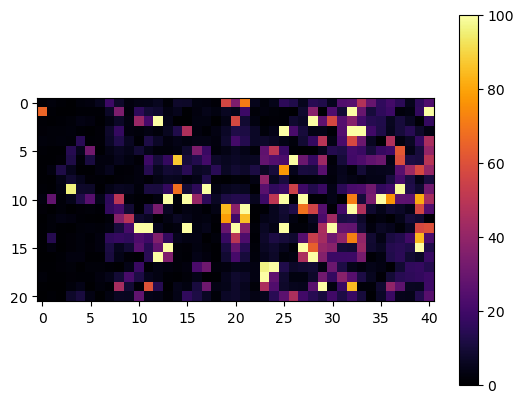

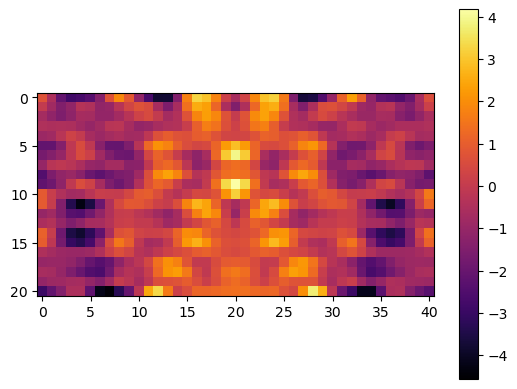

In [20]:
err_0= (np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_3[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100)
plt.imshow(np.rot90(err_0.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_3), vmax=np.max(dJ_du_3))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

In [21]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du_3[idx], 1)

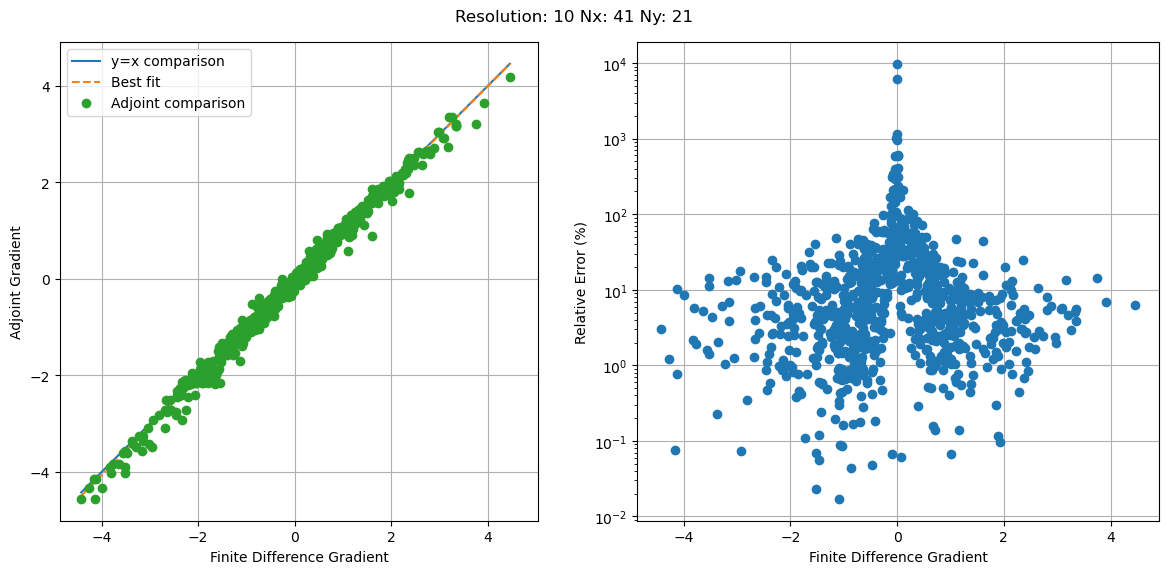

In [22]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du_3[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_3[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Nx: {} Ny: {}".format(resolution, Nx, Ny))
plt.show()

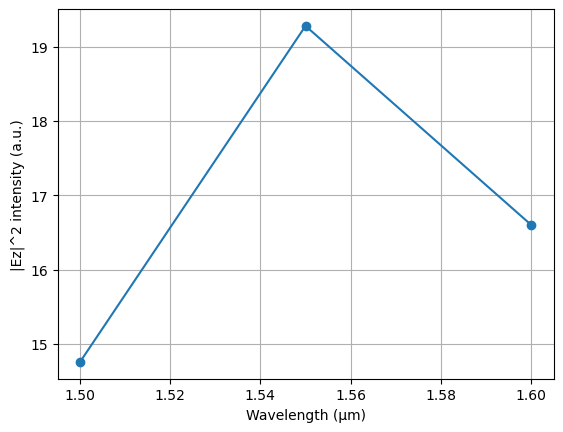

In [23]:
intensities = np.abs(opt.get_objective_arguments()[0][:,1]) ** 2

plt.figure()
plt.plot(wavelengths, intensities, "-o")
plt.grid(True)
plt.xlabel("Wavelength (μm)")
plt.ylabel("|Ez|^2 intensity (a.u.)")
plt.show()